# Phase 8: League Dashboards — The Skeptic Model

**Goal:** Professional slope charts with anti-crowding, team logos, and Elo comparison annotations.

| Feature | Detail |
|---------|--------|
| **Anti-Crowding** | `spread_labels()` jitter engine prevents mid-table overlaps |
| **Logos** | Downloaded from Transfermarkt CDN, cached locally |
| **Labels** | `Team - Rank - Points (Diff vs Elo)` |
| **Colors** | 🟢 Climbing, 🔴 Falling, ⚪ Same |
| **Output** | 5 dashboards at 300 DPI in `Report_Assets/` |

In [6]:
# =============================================================================
# Cell 1: Setup & Data Preparation
# =============================================================================

import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import requests
from io import BytesIO

warnings.filterwarnings('ignore')

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Segoe UI', 'Arial', 'DejaVu Sans']

RESULTS_DIR = os.path.join('data', 'results')
ASSETS_DIR = 'Report_Assets'
LOGO_DIR = os.path.join(ASSETS_DIR, 'logos')
os.makedirs(ASSETS_DIR, exist_ok=True)
os.makedirs(LOGO_DIR, exist_ok=True)

DPI = 300

# --- Load comparison data ---
df = pd.read_csv(os.path.join(RESULTS_DIR, 'ML_vs_Elo_Comparison.csv'))
print(f'Loaded {len(df)} teams across {df.league.nunique()} leagues')

# --- Calculate league standings ranks ---
df['rank_current'] = df.groupby('league')['pts'].rank(ascending=False, method='first').astype(int)
df['rank_projected'] = df.groupby('league')['ml_projected'].rank(ascending=False, method='first').astype(int)
df['rank_change'] = df['rank_current'] - df['rank_projected']

print(f'\nBiggest climbers (ML projects higher):')
for _, r in df.nlargest(5, 'rank_change').iterrows():
    print(f'  {r["team"]:22s} ({r["league"]:20s})  {int(r["rank_current"]):2d} -> {int(r["rank_projected"]):2d}  ({int(r["rank_change"]):+d})')
print(f'\nBiggest fallers (ML projects lower):')
for _, r in df.nsmallest(5, 'rank_change').iterrows():
    print(f'  {r["team"]:22s} ({r["league"]:20s})  {int(r["rank_current"]):2d} -> {int(r["rank_projected"]):2d}  ({int(r["rank_change"]):+d})')

Loaded 96 teams across 5 leagues

Biggest climbers (ML projects higher):
  Mainz                  (GER-Bundesliga      )  14 -> 10  (+4)
  Liverpool              (ENG-Premier League  )   6 ->  4  (+2)
  Newcastle              (ENG-Premier League  )  10 ->  8  (+2)
  Brighton               (ENG-Premier League  )  14 -> 12  (+2)
  Valencia               (ESP-La Liga         )  17 -> 15  (+2)

Biggest fallers (ML projects lower):
  FC Koln                (GER-Bundesliga      )  10 -> 14  (-4)
  Sunderland             (ENG-Premier League  )  11 -> 14  (-3)
  Man United             (ENG-Premier League  )   4 ->  6  (-2)
  Espanol                (ESP-La Liga         )   6 ->  8  (-2)
  Sevilla                (ESP-La Liga         )  14 -> 16  (-2)


In [7]:
# =============================================================================
# Cell 2: Team Color & Logo Mappings
# =============================================================================

TEAM_COLORS = {
    # === ENG-Premier League ===
    'Arsenal':       ('#EF0107', '#FFFFFF'), 'Aston Villa':   ('#670E36', '#95BFE5'),
    'Bournemouth':   ('#DA291C', '#000000'), 'Brentford':     ('#E30613', '#FFB81C'),
    'Brighton':      ('#0057B8', '#FFFFFF'), 'Burnley':       ('#6C1D45', '#99D6EA'),
    'Chelsea':       ('#034694', '#FFFFFF'), 'Crystal Palace': ('#1B458F', '#C4122E'),
    'Everton':       ('#003399', '#FFFFFF'), 'Fulham':        ('#000000', '#FFFFFF'),
    'Leeds':         ('#FFCD00', '#1D428A'), 'Liverpool':     ('#C8102E', '#FFFFFF'),
    'Man City':      ('#6CABDD', '#FFFFFF'), 'Man United':    ('#DA291C', '#FBE122'),
    'Newcastle':     ('#241F20', '#FFFFFF'), 'Nott\'m Forest': ('#DD0000', '#FFFFFF'),
    'Sunderland':    ('#EB172B', '#FFFFFF'), 'Tottenham':     ('#132257', '#FFFFFF'),
    'West Ham':      ('#7A263A', '#1BB1E7'), 'Wolves':        ('#FDB913', '#231F20'),
    # === ESP-La Liga ===
    'Barcelona':     ('#A50044', '#004D98'), 'Real Madrid':   ('#FEBE10', '#00529F'),
    'Ath Madrid':    ('#CB3524', '#272E61'), 'Sevilla':       ('#D6001C', '#FFFFFF'),
    'Betis':         ('#00954C', '#FFFFFF'), 'Sociedad':      ('#143C8B', '#FFFFFF'),
    'Villarreal':    ('#FFE114', '#005187'), 'Ath Bilbao':    ('#EE2523', '#FFFFFF'),
    'Celta':         ('#8AC3EE', '#000000'), 'Valencia':      ('#EE3524', '#FFFFFF'),
    'Mallorca':      ('#E20613', '#000000'), 'Getafe':        ('#005999', '#FFFFFF'),
    'Osasuna':       ('#D91A21', '#0A1E5C'), 'Girona':        ('#CD2534', '#FFFFFF'),
    'Espanol':       ('#007FC8', '#FFFFFF'), 'Alaves':        ('#003DA5', '#FFFFFF'),
    'Vallecano':     ('#E53027', '#FFFFFF'), 'Oviedo':        ('#003DA5', '#FFFFFF'),
    'Levante':       ('#004694', '#ED1C24'), 'Elche':         ('#006633', '#FFFFFF'),
    # === GER-Bundesliga ===
    'Bayern Munich': ('#DC052D', '#FFFFFF'), 'Dortmund':      ('#FDE100', '#000000'),
    'RB Leipzig':    ('#DD0741', '#FFFFFF'), 'Leverkusen':    ('#E32221', '#000000'),
    'Ein Frankfurt': ('#E1000F', '#000000'), 'Wolfsburg':     ('#65B32E', '#FFFFFF'),
    'Freiburg':      ('#000000', '#FFFFFF'), 'Stuttgart':     ('#E32219', '#FFFFFF'),
    'Hoffenheim':    ('#1961B5', '#FFFFFF'), 'Mainz':         ('#C3141E', '#FFFFFF'),
    'Augsburg':      ('#BA3733', '#00542F'), 'Werder Bremen': ('#1D9053', '#FFFFFF'),
    'Union Berlin':  ('#EB1923', '#FFFFFF'), 'FC Koln':       ('#ED1C24', '#FFFFFF'),
    'M\'gladbach':   ('#000000', '#18A75D'), 'Heidenheim':    ('#E2001A', '#FFFFFF'),
    'St Pauli':      ('#644222', '#FFFFFF'), 'Hamburg':        ('#005B9A', '#FFFFFF'),
    # === ITA-Serie A ===
    'Inter':         ('#003DA5', '#FCB514'), 'Milan':         ('#FB090B', '#000000'),
    'Juventus':      ('#000000', '#FFFFFF'), 'Napoli':        ('#004C99', '#FFFFFF'),
    'Roma':          ('#8E1F2F', '#F0BC42'), 'Lazio':         ('#87D8F7', '#000000'),
    'Atalanta':      ('#1E71B8', '#000000'), 'Fiorentina':    ('#482E92', '#FFFFFF'),
    'Bologna':       ('#1A2F48', '#A21E2E'), 'Torino':        ('#8B0000', '#FFFFFF'),
    'Sassuolo':      ('#00A651', '#000000'), 'Genoa':         ('#99162B', '#00387B'),
    'Udinese':       ('#000000', '#FFFFFF'), 'Cagliari':      ('#6D1A31', '#FFFFFF'),
    'Lecce':         ('#FFC72C', '#E52B2B'), 'Verona':        ('#FFEE00', '#012F5F'),
    'Parma':         ('#FDEE21', '#0033A0'), 'Como':          ('#003DA5', '#FFFFFF'),
    'Pisa':          ('#003DA5', '#FFFFFF'), 'Cremonese':     ('#DC143C', '#888888'),
    # === FRA-Ligue 1 ===
    'Paris SG':      ('#004170', '#DA291C'), 'Marseille':     ('#2FAEE0', '#FFFFFF'),
    'Lyon':          ('#DA291C', '#00529F'), 'Monaco':        ('#E7001E', '#FFFFFF'),
    'Lille':         ('#CD1719', '#FFFFFF'), 'Nice':          ('#C4122E', '#000000'),
    'Lens':          ('#FFD700', '#B30000'), 'Rennes':        ('#D2232A', '#000000'),
    'Strasbourg':    ('#005CA9', '#FFFFFF'), 'Nantes':        ('#FCE300', '#00843D'),
    'Toulouse':      ('#6B3FA0', '#FFFFFF'), 'Brest':         ('#E2001A', '#FFFFFF'),
    'Angers':        ('#000000', '#FFFFFF'), 'Auxerre':       ('#1D4091', '#FFFFFF'),
    'Le Havre':      ('#0055A4', '#FFFFFF'), 'Lorient':       ('#F58220', '#FFFFFF'),
    'Metz':          ('#850038', '#FFFFFF'), 'Paris FC':      ('#003366', '#FFFFFF'),
}

DEFAULT_COLOR = ('#555555', '#FFFFFF')

LEAGUE_STYLE = {
    'ENG-Premier League': {'color': '#3d195b', 'name': 'Premier League', 'bg': '#fafafa'},
    'ESP-La Liga':        {'color': '#ee8707', 'name': 'La Liga',        'bg': '#fafafa'},
    'GER-Bundesliga':     {'color': '#d20515', 'name': 'Bundesliga',     'bg': '#fafafa'},
    'ITA-Serie A':        {'color': '#024494', 'name': 'Serie A',        'bg': '#fafafa'},
    'FRA-Ligue 1':        {'color': '#091c3e', 'name': 'Ligue 1',       'bg': '#fafafa'},
}

def get_abbrev(name):
    special = {
        'Man City': 'MCI', 'Man United': 'MUN', 'Crystal Palace': 'CRY',
        'Nott\'m Forest': 'NFO', 'Aston Villa': 'AVL', 'West Ham': 'WHU',
        'Real Madrid': 'RMA', 'Ath Madrid': 'ATM', 'Ath Bilbao': 'ATH',
        'Bayern Munich': 'BAY', 'RB Leipzig': 'RBL', 'Ein Frankfurt': 'SGE',
        'Werder Bremen': 'SVW', 'Union Berlin': 'FCU', 'FC Koln': 'KOE',
        'Paris SG': 'PSG', 'Paris FC': 'PFC', 'Le Havre': 'HAC',
        'St Pauli': 'STP', 'M\'gladbach': 'BMG',
    }
    return special.get(name, name[:3].upper())

print(f'Team color mappings: {len(TEAM_COLORS)} teams')

Team color mappings: 96 teams


In [8]:
# =============================================================================
# Cell 3: Logo Fetcher (Transfermarkt CDN)
# =============================================================================

TM_IDS = {
    'Arsenal': 11, 'Aston Villa': 405, 'Bournemouth': 989, 'Brentford': 1148,
    'Brighton': 1237, 'Burnley': 1132, 'Chelsea': 631, 'Crystal Palace': 873,
    'Everton': 29, 'Fulham': 931, 'Leeds': 399, 'Liverpool': 31,
    'Man City': 281, 'Man United': 985, 'Newcastle': 762, "Nott'm Forest": 703,
    'Sunderland': 289, 'Tottenham': 148, 'West Ham': 379, 'Wolves': 543,
    'Barcelona': 131, 'Real Madrid': 418, 'Ath Madrid': 13, 'Sevilla': 368,
    'Betis': 150, 'Sociedad': 681, 'Villarreal': 1050, 'Ath Bilbao': 621,
    'Celta': 1531, 'Valencia': 1049, 'Mallorca': 237, 'Getafe': 3709,
    'Osasuna': 331, 'Girona': 12321, 'Espanol': 714, 'Alaves': 1108,
    'Vallecano': 367, 'Oviedo': 2687, 'Levante': 1055, 'Elche': 1311,
    'Bayern Munich': 27, 'Dortmund': 16, 'RB Leipzig': 23826, 'Leverkusen': 15,
    'Ein Frankfurt': 24, 'Wolfsburg': 82, 'Freiburg': 60, 'Stuttgart': 79,
    'Hoffenheim': 533, 'Mainz': 39, 'Augsburg': 167, 'Werder Bremen': 86,
    'Union Berlin': 89, 'FC Koln': 3, "M'gladbach": 18, 'Heidenheim': 2036,
    'St Pauli': 35, 'Hamburg': 41,
    'Inter': 46, 'Milan': 5, 'Juventus': 506, 'Napoli': 6195,
    'Roma': 12, 'Lazio': 398, 'Atalanta': 800, 'Fiorentina': 430,
    'Bologna': 1025, 'Torino': 416, 'Sassuolo': 6574, 'Genoa': 252,
    'Udinese': 410, 'Cagliari': 1390, 'Lecce': 1005, 'Verona': 276,
    'Parma': 130, 'Como': 1047, 'Pisa': 3522, 'Cremonese': 2359,
    'Paris SG': 583, 'Marseille': 244, 'Lyon': 1041, 'Monaco': 162,
    'Lille': 1082, 'Nice': 417, 'Lens': 826, 'Rennes': 273,
    'Strasbourg': 667, 'Nantes': 995, 'Toulouse': 415, 'Brest': 3911,
    'Angers': 1420, 'Auxerre': 290, 'Le Havre': 738, 'Lorient': 1158,
    'Metz': 347, 'Paris FC': 3524,
}

def download_logos():
    success, fail = 0, 0
    for team, tm_id in TM_IDS.items():
        safe_name = team.replace("'", '').replace(' ', '_')
        logo_path = os.path.join(LOGO_DIR, f'{safe_name}.png')
        if os.path.exists(logo_path):
            success += 1
            continue
        url = f'https://tmssl.akamaized.net/images/wappen/head/{tm_id}.png'
        try:
            resp = requests.get(url, timeout=5, headers={'User-Agent': 'Mozilla/5.0'})
            if resp.status_code == 200 and len(resp.content) > 100:
                img = Image.open(BytesIO(resp.content)).convert('RGBA')
                img = img.resize((80, 80), Image.LANCZOS)
                img.save(logo_path, 'PNG')
                success += 1
            else:
                fail += 1
        except:
            fail += 1
    return success, fail

def get_logo_image(team_name, zoom=0.20):
    safe_name = team_name.replace("'", '').replace(' ', '_')
    logo_path = os.path.join(LOGO_DIR, f'{safe_name}.png')
    if os.path.exists(logo_path):
        try:
            img = plt.imread(logo_path)
            return OffsetImage(img, zoom=zoom)
        except:
            pass
    return None

print('Downloading team logos...')
ok, fail = download_logos()
print(f'  Logos cached: {ok}/{len(TM_IDS)}  |  Failed: {fail}')
USE_LOGOS = ok > 50
print(f'  Logo mode: {"ENABLED" if USE_LOGOS else "DISABLED (text badges)"}')

  Logos cached: 96/96  |  Failed: 0
  Logo mode: ENABLED


In [9]:
# =============================================================================
# Cell 4: Anti-Crowding Jitter Engine + Polished Slope Chart
# =============================================================================

def spread_labels(positions, min_dist=0.6):
    """Push overlapping label positions apart while preserving order.
    
    Args:
        positions: dict of {team_name: raw_rank_position}
        min_dist: minimum distance between adjacent labels
    
    Returns:
        dict of {team_name: adjusted_y_position} for text only.
        Slope lines still anchor to the TRUE rank.
    """
    # Sort by position (rank 1 at top = highest y)
    sorted_items = sorted(positions.items(), key=lambda x: -x[1])
    adjusted = {}
    
    prev_y = None
    for team, y in sorted_items:
        if prev_y is not None and (prev_y - y) < min_dist:
            y = prev_y - min_dist  # Push down
        adjusted[team] = y
        prev_y = y
    
    return adjusted


def draw_team_badge(ax, x, y, team, size=0.016):
    """Draw a colored circle badge with team abbreviation."""
    bg, fg = TEAM_COLORS.get(team, DEFAULT_COLOR)
    badge = plt.Circle((x, y), size, color=bg, ec='#dddddd', lw=0.4,
                       transform=ax.transAxes, clip_on=False, zorder=5)
    ax.add_patch(badge)
    ax.text(x, y, get_abbrev(team), transform=ax.transAxes,
            ha='center', va='center', fontsize=5, fontweight='bold',
            color=fg, zorder=6)


def plot_league_slope(league_name, data):
    """Create a polished slope chart for one league."""
    league_data = data[data['league'] == league_name].copy()
    n_teams = len(league_data)
    style = LEAGUE_STYLE.get(league_name, {'color': '#333', 'name': league_name, 'bg': '#fafafa'})
    
    fig_height = max(13, n_teams * 0.68)
    fig, ax = plt.subplots(figsize=(16, fig_height))
    fig.patch.set_facecolor(style['bg'])
    ax.set_facecolor(style['bg'])
    ax.axis('off')
    
    # --- Layout constants ---
    left_x  = 0.32
    right_x = 0.68
    top_y   = 0.91
    total_span = 0.82
    y_spacing = total_span / max(n_teams - 1, 1)
    
    def rank_to_y(rank):
        return top_y - (rank - 1) * y_spacing
    
    # --- Compute jittered label positions ---
    left_raw  = {r['team']: rank_to_y(r['rank_current'])  for _, r in league_data.iterrows()}
    right_raw = {r['team']: rank_to_y(r['rank_projected']) for _, r in league_data.iterrows()}
    
    min_label_dist = y_spacing * 0.85  # Minimum gap between labels
    left_jittered  = spread_labels(left_raw, min_dist=min_label_dist)
    right_jittered = spread_labels(right_raw, min_dist=min_label_dist)
    
    # --- Column headers ---
    ax.text(left_x, 0.965, 'CURRENT STANDINGS', transform=ax.transAxes,
            ha='center', va='center', fontsize=14, fontweight='bold', color='#555555')
    ax.text(left_x, 0.945, 'Feb 12, 2026 (Actual)', transform=ax.transAxes,
            ha='center', va='center', fontsize=10, color='#999999', style='italic')
    ax.text(right_x, 0.965, 'ML PROJECTED', transform=ax.transAxes,
            ha='center', va='center', fontsize=14, fontweight='bold', color=style['color'])
    ax.text(right_x, 0.945, 'May 2026 (End of Season)', transform=ax.transAxes,
            ha='center', va='center', fontsize=10, color='#999999', style='italic')
    
    # --- Draw slope lines and labels per team ---
    for _, row in league_data.iterrows():
        team     = row['team']
        r_cur    = int(row['rank_current'])
        r_proj   = int(row['rank_projected'])
        cur_pts  = int(row['pts'])
        proj_pts = row['ml_projected']
        elo_diff = row['ml_vs_elo']
        change   = r_cur - r_proj  # Positive = climbing
        
        # True rank Y positions (for slope line endpoints)
        y_start_true = rank_to_y(r_cur)
        y_end_true   = rank_to_y(r_proj)
        
        # Jittered Y positions (for text labels only)
        y_start_text = left_jittered[team]
        y_end_text   = right_jittered[team]
        
        # --- Color by movement ---
        if change > 0:
            line_color = '#4bbf73'
            label_color = '#2d8a4e'
        elif change < 0:
            line_color = '#ff4b4b'
            label_color = '#cc3333'
        else:
            line_color = '#cccccc'
            label_color = '#888888'
        
        lw = min(3.5, 0.8 + abs(change) * 0.6)
        alpha = min(1.0, 0.25 + abs(change) * 0.2)
        
        # --- Slope line (anchored to TRUE rank) ---
        ax.plot([left_x, right_x], [y_start_true, y_end_true],
                color=line_color, linewidth=lw, alpha=alpha,
                transform=ax.transAxes, zorder=2, solid_capstyle='round')
        
        # --- Dots at true positions ---
        ax.plot(left_x, y_start_true, 'o', color=line_color, markersize=4,
                transform=ax.transAxes, zorder=3)
        ax.plot(right_x, y_end_true, 'o', color=line_color, markersize=4,
                transform=ax.transAxes, zorder=3)
        
        # --- LEFT SIDE: Current standing labels at JITTERED position ---
        ax.text(left_x - 0.22, y_start_text, f'{r_cur}.',
                transform=ax.transAxes, ha='right', va='center',
                fontsize=10, color='#aaaaaa', fontweight='bold')
        ax.text(left_x - 0.20, y_start_text, team,
                transform=ax.transAxes, ha='left', va='center',
                fontsize=9.5, color='#444444')
        ax.text(left_x - 0.03, y_start_text, f'{cur_pts} pts',
                transform=ax.transAxes, ha='right', va='center',
                fontsize=8.5, color='#999999')
        
        # --- LEFT: Logo/badge at TRUE dot position ---
        if USE_LOGOS:
            logo = get_logo_image(team, zoom=0.16)
            if logo:
                ab = AnnotationBbox(logo, (left_x, y_start_true),
                                    xycoords=ax.transAxes, frameon=False, zorder=5)
                ax.add_artist(ab)
            else:
                draw_team_badge(ax, left_x, y_start_true, team)
        else:
            draw_team_badge(ax, left_x, y_start_true, team)
        
        # --- RIGHT SIDE: Projected labels at JITTERED position ---
        # Format: Team Name  Rank  (Pts, +/-X.X vs Elo)
        elo_sign = '+' if elo_diff >= 0 else ''
        right_label = f'{team}  ({proj_pts:.0f} pts, {elo_sign}{elo_diff:.1f} vs Elo)'
        
        ax.text(right_x + 0.03, y_end_text, right_label,
                transform=ax.transAxes, ha='left', va='center',
                fontsize=9, color=label_color, fontweight='bold')
        ax.text(right_x + 0.22, y_end_text, f'{r_proj}',
                transform=ax.transAxes, ha='left', va='center',
                fontsize=10, color=style['color'], fontweight='bold')
        
        # --- RIGHT: Logo/badge at TRUE dot position ---
        if USE_LOGOS:
            logo2 = get_logo_image(team, zoom=0.16)
            if logo2:
                ab2 = AnnotationBbox(logo2, (right_x, y_end_true),
                                     xycoords=ax.transAxes, frameon=False, zorder=5)
                ax.add_artist(ab2)
            else:
                draw_team_badge(ax, right_x, y_end_true, team)
        else:
            draw_team_badge(ax, right_x, y_end_true, team)
        
        # --- Movement arrow for big movers ---
        if abs(change) >= 2:
            arrow = '▲' if change > 0 else '▼'
            ax.text(right_x + 0.25, y_end_text, f'{arrow}{abs(change)}',
                    transform=ax.transAxes, ha='left', va='center',
                    fontsize=9, color=label_color, fontweight='bold')
    
    # --- Thin connector lines from jittered text to true dot (if jittered) ---
    for _, row in league_data.iterrows():
        team = row['team']
        y_true_l = rank_to_y(row['rank_current'])
        y_jit_l  = left_jittered[team]
        if abs(y_true_l - y_jit_l) > 0.001:
            ax.plot([left_x - 0.03, left_x - 0.02], [y_jit_l, y_true_l],
                    color='#dddddd', linewidth=0.5, transform=ax.transAxes, zorder=1)
        y_true_r = rank_to_y(row['rank_projected'])
        y_jit_r  = right_jittered[team]
        if abs(y_true_r - y_jit_r) > 0.001:
            ax.plot([right_x + 0.02, right_x + 0.03], [y_true_r, y_jit_r],
                    color='#dddddd', linewidth=0.5, transform=ax.transAxes, zorder=1)
    
    # --- Title ---
    ax.text(0.5, 1.02, style['name'], transform=ax.transAxes,
            ha='center', va='bottom', fontsize=24, fontweight='bold', color=style['color'])
    ax.text(0.5, 1.005, 'The \"Skeptic\" ML Model: Current vs Projected Standings',
            transform=ax.transAxes, ha='center', va='top',
            fontsize=11, color='#888888', style='italic')
    
    # --- Legend bar ---
    legend_y = 0.015
    ax.text(0.28, legend_y, '\u25CF Climbing (Projected higher)', transform=ax.transAxes,
            fontsize=9, va='center', color='#4bbf73', fontweight='bold')
    ax.text(0.52, legend_y, '\u25CF Falling (Projected lower)', transform=ax.transAxes,
            fontsize=9, va='center', color='#ff4b4b', fontweight='bold')
    ax.text(0.73, legend_y, '|  Line thickness = magnitude', transform=ax.transAxes,
            fontsize=8, va='center', color='#aaaaaa')
    
    # --- Save ---
    safe = league_name.replace(' ', '_').replace('-', '_')
    path = os.path.join(ASSETS_DIR, f'Dashboard_{safe}.png')
    plt.savefig(path, dpi=DPI, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()
    plt.close()
    print(f'  Saved: {path}')
    return path

print('Polished slope chart function ready.')
print('  Features: Anti-crowding jitter, logos, Elo diff annotations')

Polished slope chart function ready.
  Features: Anti-crowding jitter, logos, Elo diff annotations


Generating Polished League Dashboards...

>>> ENG-Premier League (20 teams)


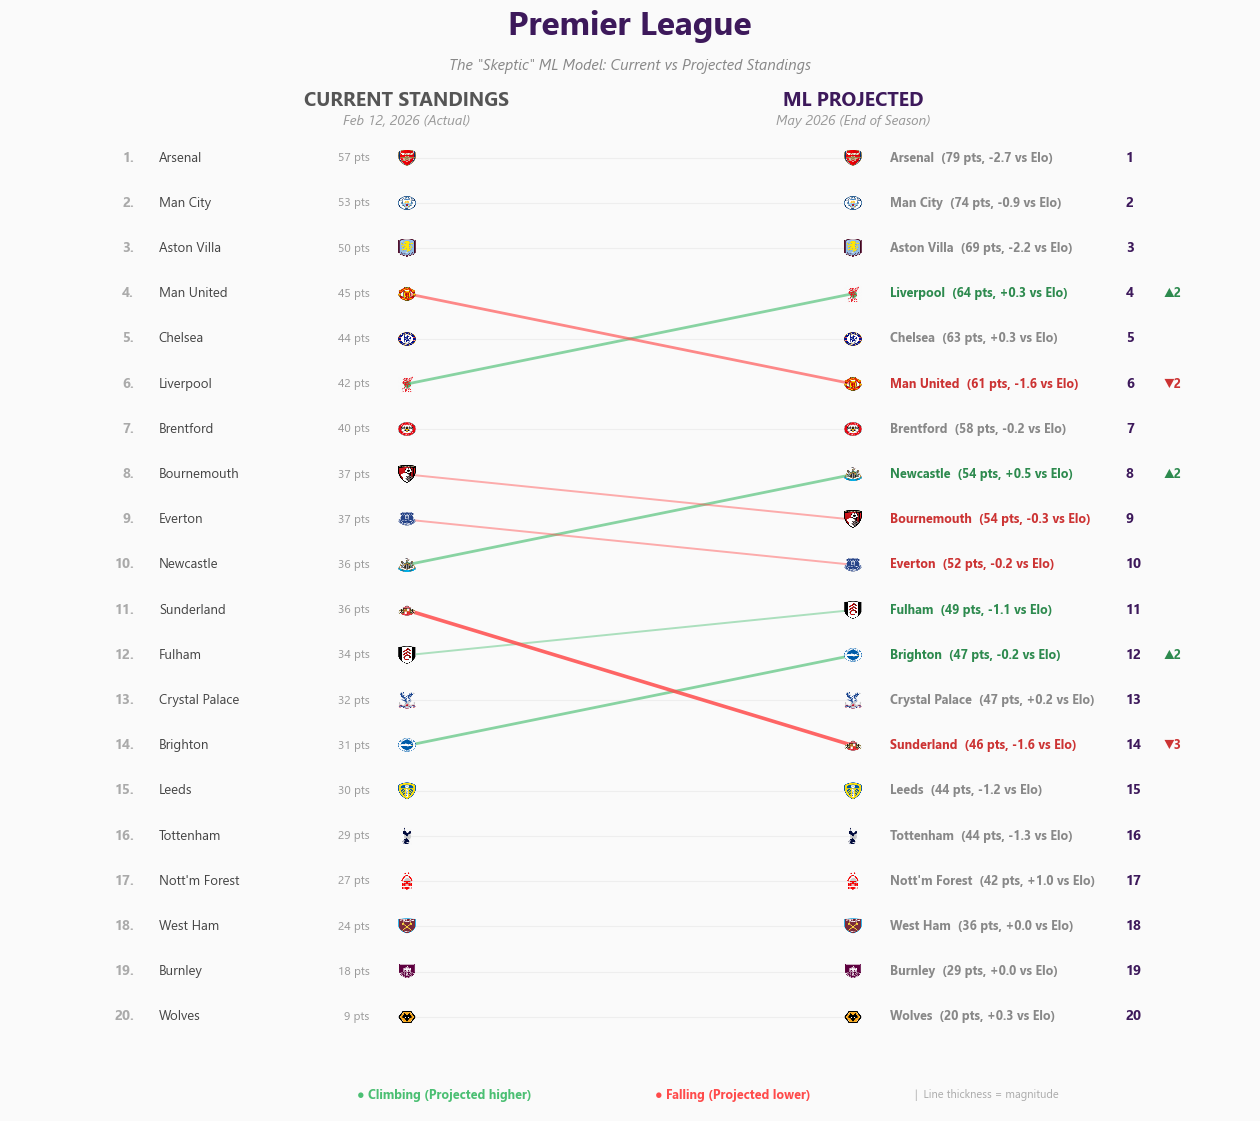

  Saved: Report_Assets\Dashboard_ENG_Premier_League.png

>>> ESP-La Liga (20 teams)


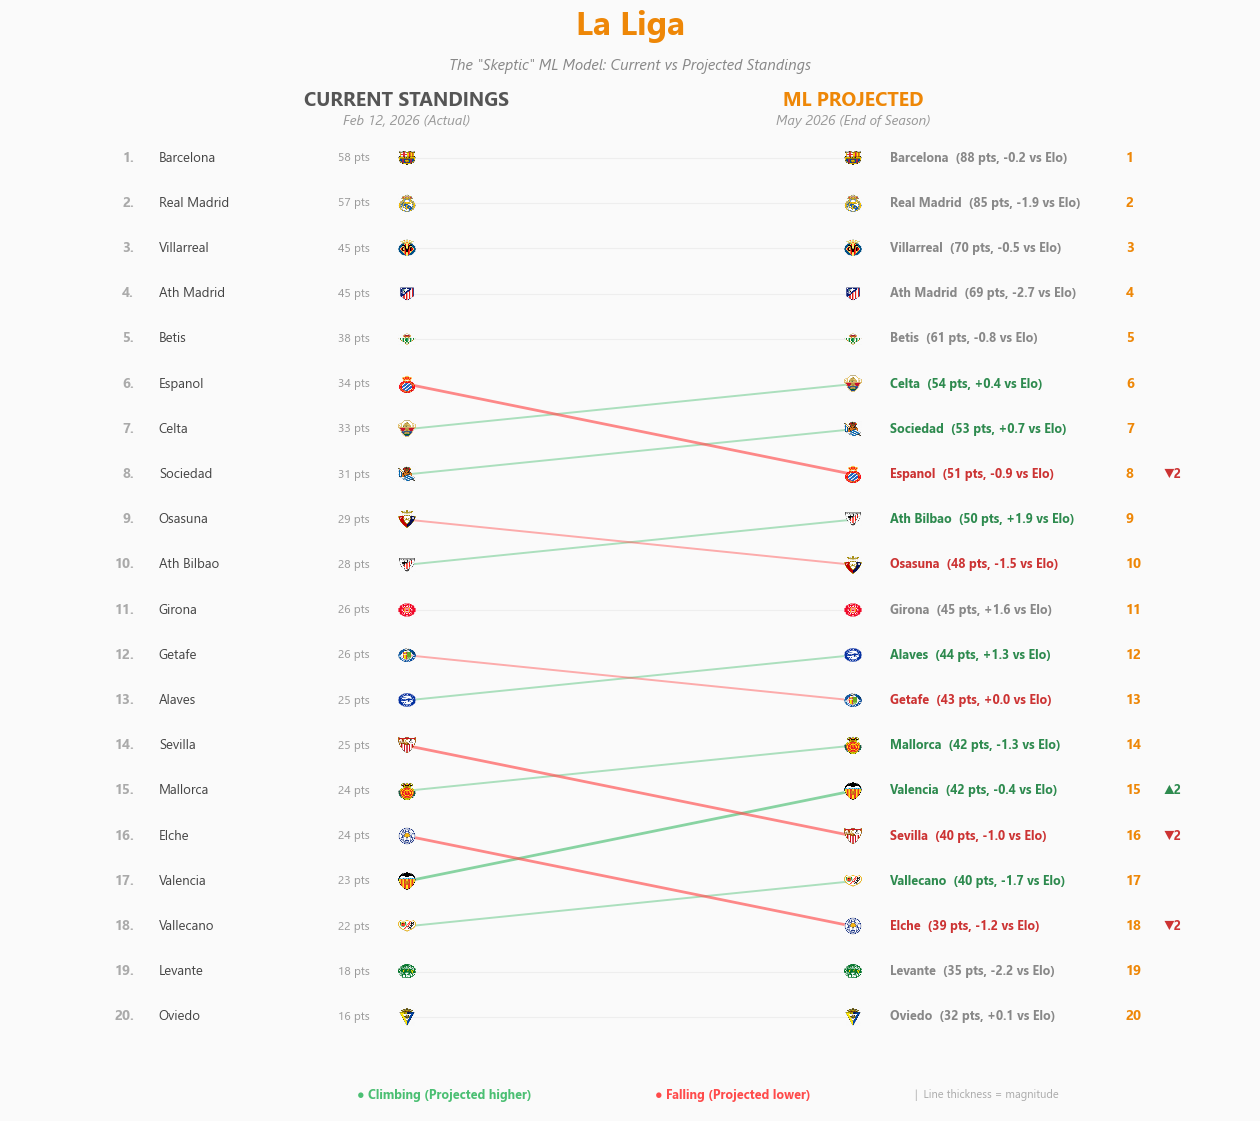

  Saved: Report_Assets\Dashboard_ESP_La_Liga.png

>>> FRA-Ligue 1 (18 teams)


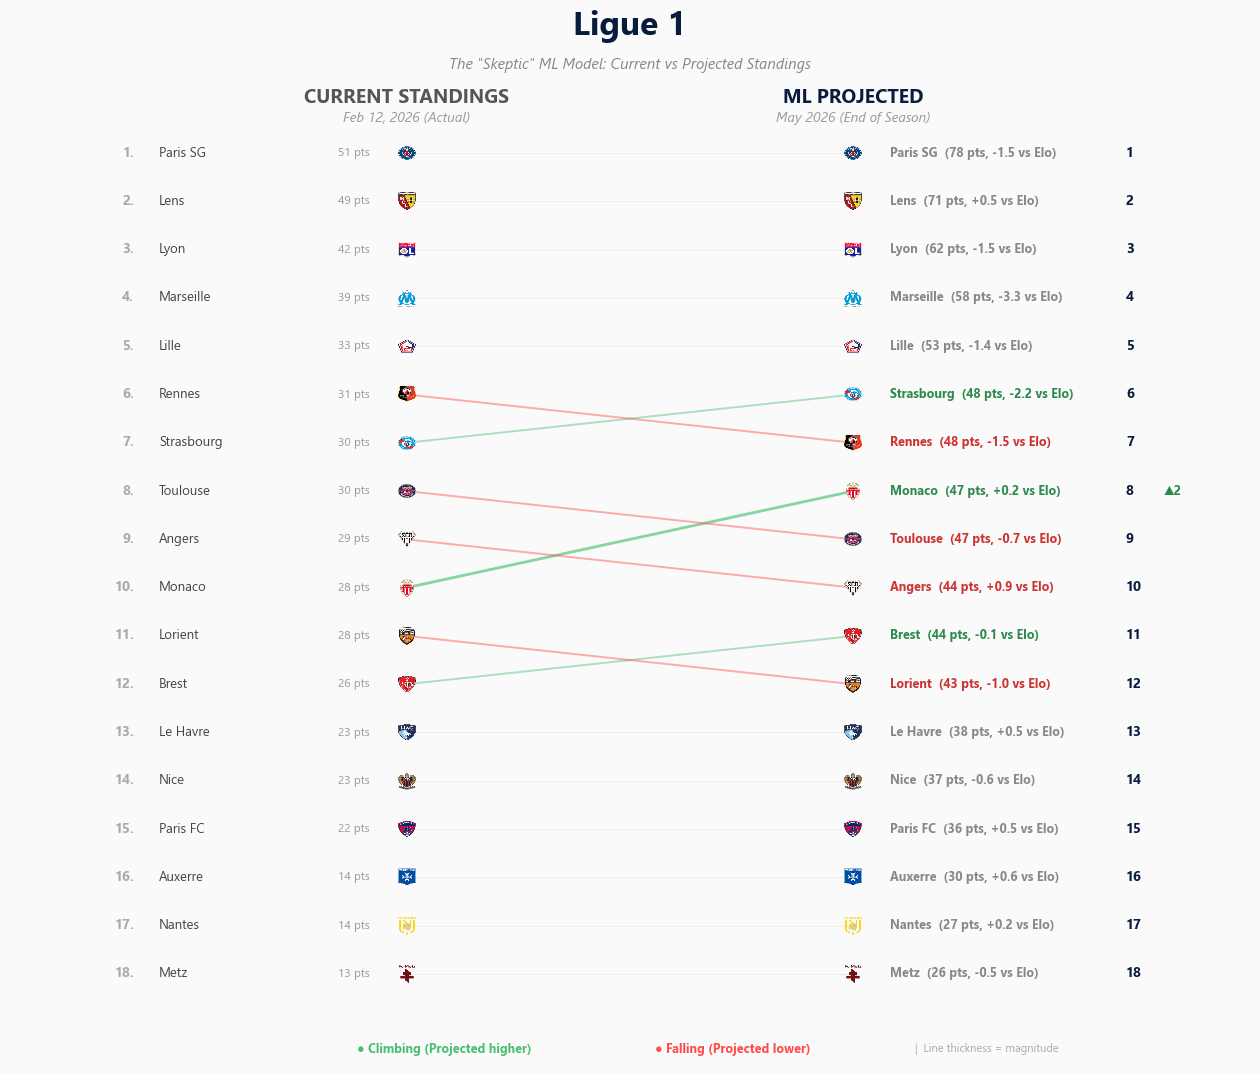

  Saved: Report_Assets\Dashboard_FRA_Ligue_1.png

>>> GER-Bundesliga (18 teams)


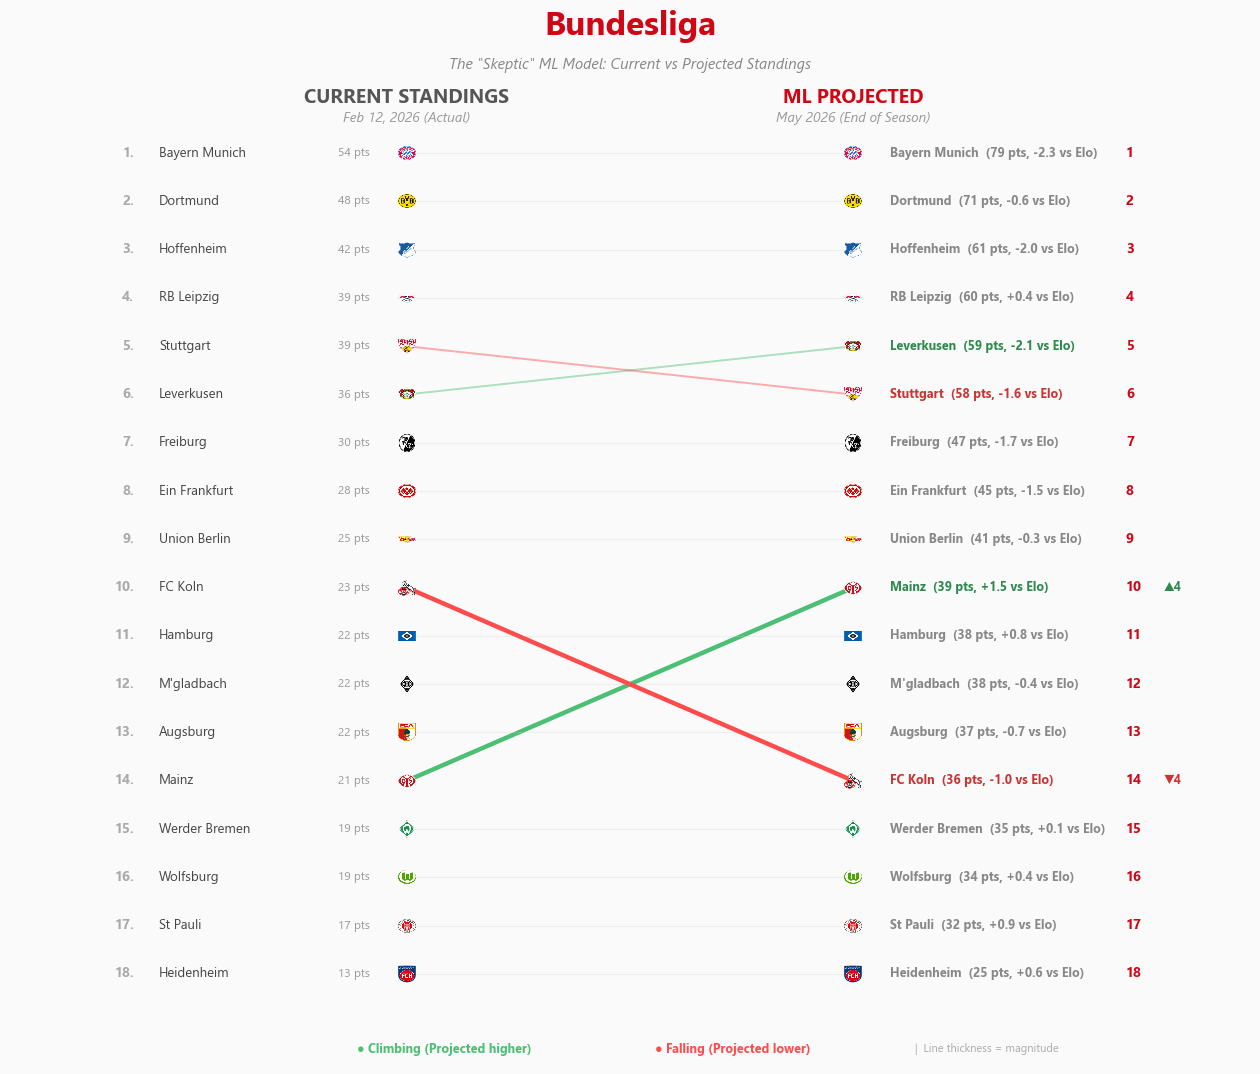

  Saved: Report_Assets\Dashboard_GER_Bundesliga.png

>>> ITA-Serie A (20 teams)


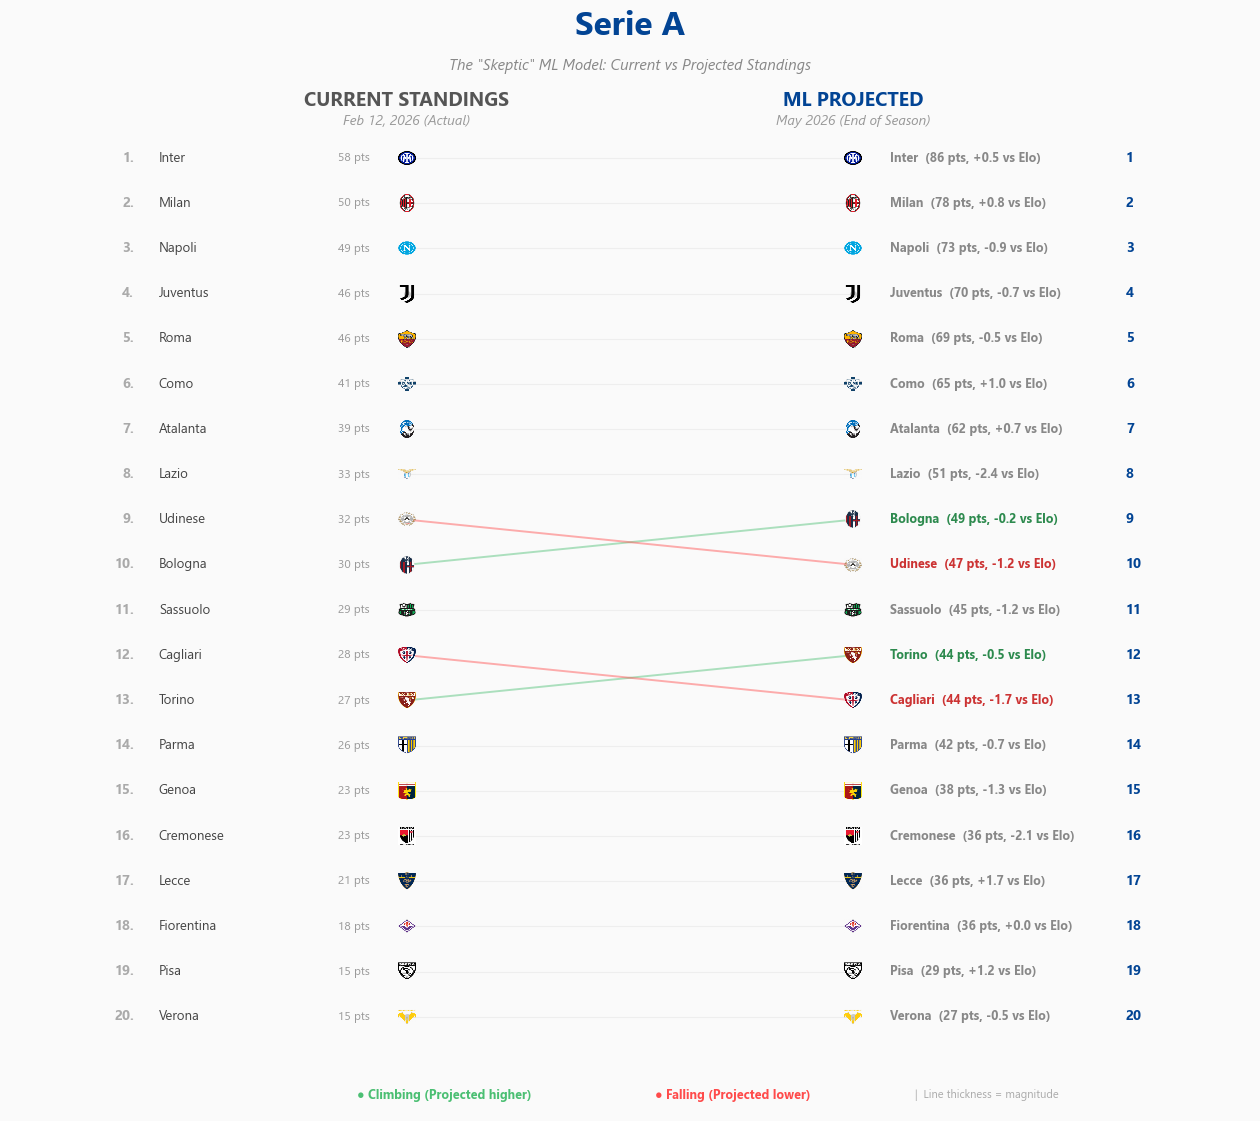

  Saved: Report_Assets\Dashboard_ITA_Serie_A.png

All 5 dashboards generated!

Output files:
  [    750 KB]  Dashboard_ENG_Premier_League.png
  [    776 KB]  Dashboard_ESP_La_Liga.png
  [    640 KB]  Dashboard_FRA_Ligue_1.png
  [    647 KB]  Dashboard_GER_Bundesliga.png
  [    627 KB]  Dashboard_ITA_Serie_A.png

All assets in: Report_Assets/
DPI: 300  |  Logo mode: ENABLED
Phase 8 complete.


In [10]:
# =============================================================================
# Cell 5: Generate All 5 League Dashboards
# =============================================================================

print('Generating Polished League Dashboards...')
print('=' * 60)

dashboard_paths = []
for league in sorted(df['league'].unique()):
    n = len(df[df['league'] == league])
    print(f'\n>>> {league} ({n} teams)')
    path = plot_league_slope(league, df)
    dashboard_paths.append(path)

print(f'\n{"=" * 60}')
print(f'All {len(dashboard_paths)} dashboards generated!')
print(f'\nOutput files:')
for p in dashboard_paths:
    size_kb = os.path.getsize(p) / 1024
    print(f'  [{size_kb:>7.0f} KB]  {os.path.basename(p)}')

print(f'\nAll assets in: {ASSETS_DIR}/')
print(f'DPI: {DPI}  |  Logo mode: {"ENABLED" if USE_LOGOS else "TEXT BADGES"}')
print(f'Phase 8 complete.')